In [99]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, make_scorer, f1_score
from collections import Counter
import scipy.stats as stats # for the breakpoints in SAX
from scipy.stats import norm
from Symbol import SYMBOLS
from distances import MINDIST, TRENDIST
from SAX_transf import SAX_transform
import warnings 
from dtw import dtw
from sklearn.model_selection import GridSearchCV
from tslearn.neighbors import KNeighborsTimeSeriesClassifier
from tslearn.utils import to_time_series_dataset
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import roc_curve, auc
import sax_clustering

warnings.filterwarnings('ignore')
import os
import aeon
from aeon.datasets import load_classification

In [100]:
train_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TRAIN.ts")
test_path = os.path.join(os.getcwd(), "datasets/classification/ECG200/ECG200_TEST.ts")

X_train = pd.read_csv(train_path, 
                      sep=",", 
                      header=None
                      )

X_train.columns = list(X_train.columns[:-1]) + ['label']
x_train, y_train = X_train.iloc[:, :-1], X_train["label"]

y_train = y_train.replace(-1, 0)

X_test = pd.read_csv(test_path, 
                      sep=",", 
                      header=None
                      )

X_test.columns = list(X_test.columns[:-1]) + ['label']
x_test, y_test = X_test.iloc[:, :-1], X_test["label"]

y_test = y_test.replace(-1, 0)

In [101]:
sax = SYMBOLS(X_train=X_train,
                X_test=X_test,
                method="SAX",
                k=1
                )

In [ ]:
sax._predict()

In [ ]:
SAX_list_k_means_intra_cluster = []
SAX_list_k_means_inter_cluster = []
sax = SYMBOLS(X_train, 
                X_test, 
                'SAX', 
                num_segments=10, 
                alphabet_size=10)

for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20]:
    _, _, intra_cluster_mean_distance, inter_cluster_mean_distance = sax_clustering.k_means_sax(sax, 10, k)
    SAX_list_k_means_inter_cluster.append(inter_cluster_mean_distance)
    SAX_list_k_means_intra_cluster.append(intra_cluster_mean_distance)
    print('*')

In [ ]:
TSAX_list_k_means_intra_cluster = []
TSAX_list_k_means_inter_cluster = []
tsax = SYMBOLS(X_train, 
               X_test,
               'TSAX', 
               num_segments=10, 
               alphabet_size=10)
for k in [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20]:
    _, _, intra_cluster_mean_distance, inter_cluster_mean_distance = sax_clustering.k_means_sax(tsax, 10, k)
    TSAX_list_k_means_inter_cluster.append(inter_cluster_mean_distance)
    TSAX_list_k_means_intra_cluster.append(intra_cluster_mean_distance)
    print('*')

Convergence atteinte après 1 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 3 itérations.
*
Convergence atteinte après 5 itérations.
*


TypeError: 'Text' object is not callable

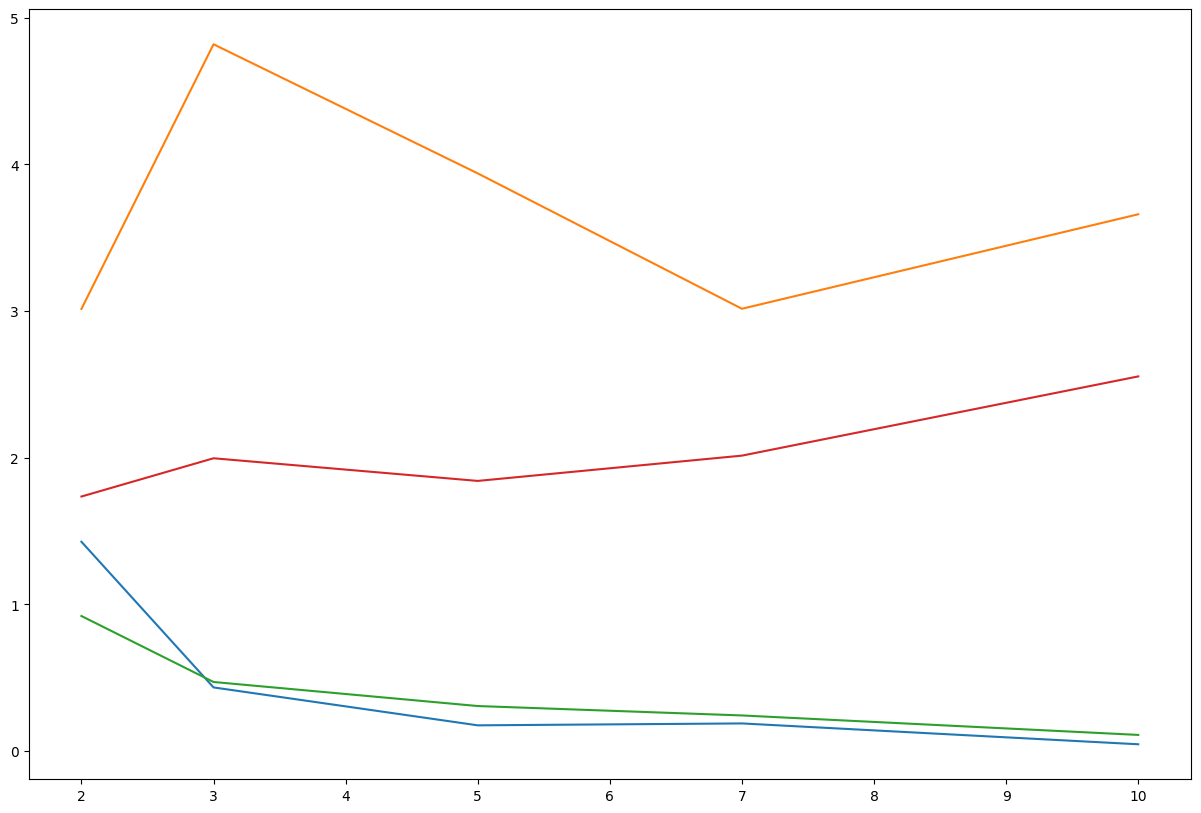

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
x = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 13, 15, 20]
ax.plot(x, SAX_list_k_means_intra_cluster, label="SAX K-means intra-cluster mean distance vs K")
ax.plot(x, SAX_list_k_means_inter_cluster, label="SAX K-means inter-cluster mean distance vs K")
ax.plot(x, TSAX_list_k_means_intra_cluster, label="TSAX K-means intra-cluster mean distance vs K")
ax.plot(x, TSAX_list_k_means_inter_cluster, label="TSAX K-means inter-cluster mean distance vs K")
ax.title("Intra-cluster and Inter-cluster Mean Distance vs. Number of Cluster for each method")
ax.legend()

In [75]:
def calculate_distance_matrix(sax, clusters):
    """
    Calcule la matrice des distances entre les clusters actuels.
    """
    if sax.method == "TSAX":
        dist = TRENDIST(sax.alphabet_size, sax.train_ts_length, sax.angle_breakpoint_alphabet_size)
    else: 
        dist = MINDIST(sax.alphabet_size, sax.train_ts_length)

    num_clusters = len(clusters)
    distance_matrix = np.full((num_clusters, num_clusters), np.inf)

    for i in range(num_clusters):
        for j in range(i + 1, num_clusters):
            # Calculer la distance entre les centroïdes des clusters i et j
            if sax.method == "TSAX":
                d = dist.tsax_mindist(clusters[i]['representative'], clusters[j]['representative'])
            else: 
                d = dist.mindist(clusters[i]['representative'], clusters[j]['representative'])

            distance_matrix[i, j] = d
            distance_matrix[j, i] = d

    return distance_matrix

# Fonction principale pour le clustering hiérarchique
def hierarchical_clustering(sax, num_cluster):
    """
    Implémente le clustering hiérarchique agglomératif from scratch.
    
    Paramètres :
    - data : pd.DataFrame (n, p) : les données d'entrée.
    - max_iter : int : le nombre maximum d'itérations avant d'arrêter.
    - num_cluster : int : le nombre de clusters final souhaité.

    Retourne :
    - clusters : Liste contenant les clusters finaux.
    - linkage_matrix : np.ndarray : matrice des liens pour suivre les fusions de clusters.
    """

    data = sax.symbolized_x_train
    num_samples = data.shape[0]

    # on aura beosin de la métrique pour recalculr les représentants de chaque cluster fusioné 
    if sax.method == "TSAX":
        D = TRENDIST(sax.alphabet_size, sax.train_ts_length, sax.angle_breakpoint_alphabet_size)
    else: 
        D = MINDIST(sax.alphabet_size, sax.train_ts_length)
    
    # Initialisation : chaque point est un cluster
    clusters = []
    linkage_matrix = []  # Liste pour stocker la matrice des liens
    current_cluster_id = num_samples  # On commence à partir de num_samples pour les nouveaux clusters

    for i in range(num_samples):
        clusters.append({
            'id': i,  # Identifiant unique du cluster
            'points': [data.iloc[i, :][0]],  # Liste des points dans le cluster
            'representative': data.iloc[i, :][0]  # Représentant initial = le point lui-même
        })

    iteration = 0
    
    while len(clusters) > num_cluster:
        # Étape 1 : Calculer la matrice des distances
        distance_matrix = calculate_distance_matrix(sax, clusters)

        # Étape 2 : Trouver les clusters les plus proches à fusionner
        i, j = np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

        # Récupérer les distances minimales et les IDs des clusters fusionnés
        dist = distance_matrix[i, j]
        id_i, id_j = clusters[i]['id'], clusters[j]['id']

        # Ajouter à la linkage_matrix avec une vérification
        if len(clusters[i]['points']) > 0 and len(clusters[j]['points']) > 0:
            linkage_matrix.append([id_i, id_j, dist, len(clusters[i]['points']) + len(clusters[j]['points'])])
        else:
            raise ValueError(f"Fusion invalide, l'un des clusters {id_i} ou {id_j} est vide ou non formé correctement.")

        # Étape 3 : Fusionner les deux clusters trouvés
        merged_points = clusters[i]['points'] + clusters[j]['points']

        if sax.method == "TSAX":
            rep = [sum(D.tsax_mindist(p, q) for q in merged_points) for p in merged_points]
        else: 
            rep = [sum(D.mindist(p, q) for q in merged_points) for p in merged_points]

        merged_cluster = {
            'id': current_cluster_id,  # Nouveau cluster avec un identifiant unique
            'points': merged_points,  # Fusion des points
            'representative': merged_points[np.argmin(rep)]  # Point médian
        }

        # Supprimer les clusters i et j et ajouter le nouveau cluster
        clusters.pop(max(i, j))  # Supprimer le plus grand index d'abord pour éviter les décalages
        clusters.pop(min(i, j))
        clusters.append(merged_cluster)

        # Incrémenter l'ID pour le prochain cluster fusionné
        current_cluster_id += 1
        
        # Incrémenter le compteur d'itérations
        iteration += 1

    # Convertir linkage_matrix en tableau numpy
    linkage_matrix = np.array(linkage_matrix)

    return clusters, linkage_matrix

In [76]:
clusters, linkage_matrix = hierarchical_clustering(sax, 5)

In [77]:
from scipy.cluster.hierarchy import dendrogram

KeyError: 104

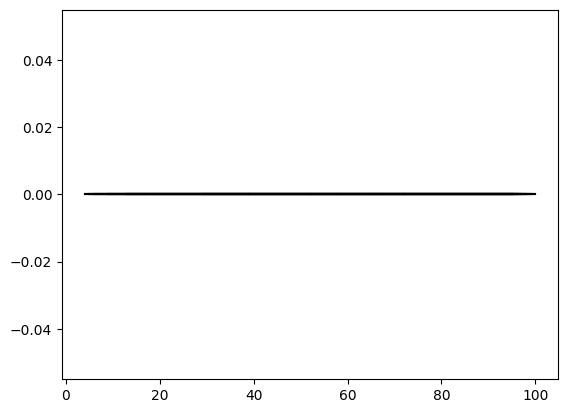

In [82]:
import matplotlib.pyplot as plt
import numpy as np
def plot_dendrogram_manual(linkage_matrix):
    """
    Trace un dendrogramme à partir d'une matrice de liens (linkage_matrix) de manière manuelle.
    
    Paramètres :
    - linkage_matrix : np.ndarray : la matrice de liens (Z) générée par un clustering hiérarchique.
    """
    # Calculer le nombre de clusters à partir de la matrice de liens
    n = linkage_matrix.shape[0]  # Le nombre de clusters initiaux
    
    # Créer un tableau pour les coordonnées des lignes
    x_vals = np.zeros((linkage_matrix.shape[0] * 2 + 1, 2))  # Tableau des coordonnées des clusters
    y_vals = np.zeros((linkage_matrix.shape[0] * 2 + 1, 2))  # Tableau des hauteurs
    
    # Dictionnaire pour garder une trace des indices des clusters
    cluster_indices = {i: i for i in range(n)}  # Chaque point commence avec son propre indice
    
    # Liste pour stocker les hauteurs des clusters pour chaque fusion
    heights = []
    
    # Identifier le prochain indice de cluster disponible
    next_cluster_idx = n
    
    for i, (cluster1, cluster2, dist, _) in enumerate(linkage_matrix):
        # Récupérer les indices des clusters à fusionner
        cluster1_idx = int(cluster1)
        cluster2_idx = int(cluster2)
        
        # Les nouvelles coordonnées pour le dendrogramme
        y_val = dist
        heights.append(y_val)
        
        # Mettez à jour les coordonnées X et Y pour le lien
        x_vals[i + n, 0] = cluster_indices[cluster1_idx]  # X pour le cluster 1
        x_vals[i + n, 1] = cluster_indices[cluster2_idx]  # X pour le cluster 2
        y_vals[i + n, 0] = y_val
        y_vals[i + n, 1] = y_val
        
        # Créer un nouveau cluster et lui assigner un nouvel index
        new_cluster_idx = next_cluster_idx
        next_cluster_idx += 1
        
        # Mise à jour de l'indice du nouveau cluster dans le dictionnaire
        cluster_indices[new_cluster_idx] = new_cluster_idx
        
        # Trace de la ligne entre les clusters
        plt.plot([cluster_indices[cluster1_idx], cluster_indices[cluster2_idx]], 
                 [y_val, y_val], color='black')  # ligne horizontale
        plt.plot([cluster_indices[cluster1_idx], new_cluster_idx], 
                 [y_val, y_val], color='black')  # ligne vers le nouveau cluster
        plt.plot([cluster_indices[cluster2_idx], new_cluster_idx], 
                 [y_val, y_val], color='black')  # ligne vers le nouveau cluster
        
        # Mise à jour des indices de clusters dans le dictionnaire
        cluster_indices[cluster1_idx] = new_cluster_idx
        cluster_indices[cluster2_idx] = new_cluster_idx

    # Configuration du tracé
    plt.title('Dendrogramme')
    plt.xlabel('Indice des clusters')
    plt.ylabel('Distance (hauteur)')
    
    # Ajuster l'échelle des axes
    plt.xticks(np.arange(n, n + len(linkage_matrix), 1))
    plt.show()

plot_dendrogram_manual(linkage_matrix)

In [68]:
clusters.key()

AttributeError: 'list' object has no attribute 'key'

In [47]:
data = sax.symbolized_x_train
num_samples = data.shape[0]
# Initialisation : chaque point est un cluster
clusters = []

for i in range(num_samples):
    clusters.append({
        'id': i,  # Identifiant unique du cluster
        'points': [data.iloc[i, :][0]],  # Liste des points dans le cluster
        'centroid': data.iloc[i, :][0]  # Centroïde initial = le point lui-même
    })

In [58]:
clusters

[{'id': 0,
  'points': ['mpigfcbbaabdhjlmlllm'],
  'centroid': 'mpigfcbbaabdhjlmlllm'},
 {'id': 1,
  'points': ['kgbbbabelnnnnllkmkfi'],
  'centroid': 'kgbbbabelnnnnllkmkfi'},
 {'id': 2,
  'points': ['lpkgfcbbaabeikmmmmlm'],
  'centroid': 'lpkgfcbbaabeikmmmmlm'},
 {'id': 3,
  'points': ['pnmkggdbaaabeikkjjjm'],
  'centroid': 'pnmkggdbaaabeikkjjjm'},
 {'id': 4,
  'points': ['pmmdcbaaafmnmlkkjjli'],
  'centroid': 'pmmdcbaaafmnmlkkjjli'},
 {'id': 5,
  'points': ['ohicbbaabfkmmlmlllmk'],
  'centroid': 'ohicbbaabfkmmlmlllmk'},
 {'id': 6,
  'points': ['pphgeddcbaabeiklllll'],
  'centroid': 'pphgeddcbaabeiklllll'},
 {'id': 7,
  'points': ['ophgecbaabejklklmllj'],
  'centroid': 'ophgecbaabejklklmllj'},
 {'id': 8,
  'points': ['pggdbbaabhmnmmmllkmj'],
  'centroid': 'pggdbbaabhmnmmmllkmj'},
 {'id': 9,
  'points': ['pnmdcbaabhmlllkkjiji'],
  'centroid': 'pnmdcbaabhmlllkkjiji'},
 {'id': 10,
  'points': ['ooijfecaaachlmllklnj'],
  'centroid': 'ooijfecaaachlmllklnj'},
 {'id': 11,
  'points': ['mpjhd

In [51]:
if sax.method == "TSAX":
    dist = TRENDIST(sax.alphabet_size, sax.train_ts_length, sax.angle_breakpoint_alphabet_size)
else: 
    dist = MINDIST(sax.alphabet_size, sax.train_ts_length)

num_clusters = len(clusters)
distance_matrix = np.full((num_clusters, num_clusters), np.inf)

for i in range(num_clusters):
    for j in range(i + 1, num_clusters):
        # Calculer la distance entre les centroïdes des clusters i et j
        if sax.method == "TSAX":
            d = dist.tsax_mindist(clusters[i]['centroid'], clusters[j]['centroid'])
        else: 
            d = dist.mindist(clusters[i]['centroid'], clusters[j]['centroid'])

        distance_matrix[i, j] = d
        distance_matrix[j, i] = d

distance_matrix

array([[        inf, 10.79707948,  0.35528956, ...,  3.90599569,
         6.60308673,  7.46232768],
       [10.79707948,         inf, 10.79837422, ...,  8.09804139,
         7.19328431,  5.74004527],
       [ 0.35528956, 10.79837422,         inf, ...,  3.7350633 ,
         6.44214886,  7.46044122],
       ...,
       [ 3.90599569,  8.09804139,  3.7350633 , ...,         inf,
         3.23821221,  3.44336872],
       [ 6.60308673,  7.19328431,  6.44214886, ...,  3.23821221,
                inf,  1.99038946],
       [ 7.46232768,  5.74004527,  7.46044122, ...,  3.44336872,
         1.99038946,         inf]])

In [52]:
np.unravel_index(np.argmin(distance_matrix), distance_matrix.shape)

(4, 58)